In [368]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocessing Notebook

### Imports

In [369]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from matplotlib import pyplot as plt
import numpy as np

### Dataset loading

In [370]:
# Load data

y_data = {}
y_test_data = pd.read_csv(f"../data/test.csv")
X_test_estimated_data = {}
X_train_estimated_data = {}
X_train_observed_data = {}
locations = ["A", "B", "C"]

for location in locations:
    y_data[location] = pd.read_parquet(f"../data/{location}/train_targets.parquet")

    X_test_estimated_data[location] = pd.read_parquet(
        f"../data/{location}/X_test_estimated.parquet"
    )
    X_train_estimated_data[location] = pd.read_parquet(
        f"../data/{location}/X_train_estimated.parquet"
    )
    X_train_observed_data[location] = pd.read_parquet(
        f"../data/{location}/X_train_observed.parquet"
    )

In [371]:
# Combine data

combine_data = (
    lambda data: pd.concat(data.values(), keys=data.keys())
    .reset_index()
    .drop(columns="level_1")
    .rename(columns={"level_0": "location"})
)

y_test_data = y_test_data.rename(columns={"prediction": "pv_measurement"})[
    ["time", "location", "pv_measurement"]
]

y = combine_data(y_data).sort_values(by=["time", "location"])

y = pd.concat([y, y_test_data]).sort_values(by=["time", "location"])
y["time"] = pd.to_datetime(y["time"])

X_train_observed = combine_data(X_train_observed_data).assign(data_type="observed")
X_train_estimated = combine_data(X_train_estimated_data).assign(data_type="estimated")
X_test_estimated = combine_data(X_test_estimated_data).assign(data_type="test")

X = pd.concat([X_train_observed, X_train_estimated, X_test_estimated]).sort_values(
    by=["date_forecast", "location"]
)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (413791, 49)
y shape: (101248, 3)


### Data cleaning

In [372]:
print("Categorical Features:")
print([column for column in X.columns if "idx" in column])

Categorical Features:
['dew_or_rime:idx', 'is_day:idx', 'is_in_shadow:idx', 'precip_type_5min:idx', 'snow_drift:idx']


#### Resample data to hourly granularity

In [373]:
# Custom aggregation function
def custom_resample(aggregation_dict):
    result = {}
    for column in X.columns:
        if column in ["date_forecast"]:
            continue

        aggregation = aggregation_dict.get(column, 'mean')  # Use 'mean' by default

        result[column] = aggregation
    return result

# Specify the aggregation method for specific columns
aggregation_dict = {
    "location": "first",
    "data_type": "first",

    "is_day:idx": "first",
    "is_in_shadow:idx": "first",
    "precip_type_5min:idx": "first",
    "dew_or_rime:idx": "first",
    "snow_drift:idx": "first",
}

X = (
    X.set_index("date_forecast")
    .groupby("location")
    .resample("H")
    .apply(custom_resample(aggregation_dict))
    .drop(columns=["location"])
    .reset_index()
    .sort_values(by=["date_forecast", "location"])
    .reset_index(drop=True)
)

#### Remove NaN rows

In [374]:
# Find all rows that only contain NaN in X

nan_rows = X[X.drop(columns=["date_forecast", "location"]).isna().all(axis=1)].index

X = X.drop(nan_rows).reset_index(drop=True)
display(X.describe())

# Find all rows that only contain NaN in y

nan_rows = y[y.drop(columns=["time", "location"]).isna().all(axis=1)].index

y = y.drop(nan_rows).reset_index(drop=True)
display(y.describe())

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,...,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,date_calc
count,103450,103450.000000,103450.000000,85710.000000,1.034500e+05,103450.000000,95988.000000,103450.000000,103450.000000,103450.000000,...,103450.000000,103450.000000,103450.000000,103450.000000,103450.000000,103450.000000,103450.000000,103450.000000,103450.000000,15342
mean,2021-02-27 11:19:43.458675712,6.022451,1.255468,2818.218750,5.340856e+05,148.357071,1728.615723,0.002707,275.193604,40.692169,...,-0.686007,0.056825,279.437866,73.615753,33047.601562,3.017211,0.677701,0.670877,0.000048,2023-02-14 19:23:08.778255872
min,2019-01-01 00:00:00,0.500000,1.139250,27.600000,0.000000e+00,0.000000,27.299997,-1.000000,247.425003,0.000000,...,-49.931999,0.000000,258.024994,0.000000,132.375000,0.025000,-7.225000,-8.400000,-0.100000,2022-10-27 07:00:18
25%,2020-02-15 04:00:00,4.000000,1.230000,1063.206177,0.000000e+00,0.000000,602.687500,0.000000,270.600006,0.000000,...,-17.985250,0.000000,274.799988,52.900002,17214.430664,1.675000,-1.325000,-0.600000,0.000000,2022-12-20 08:01:43
50%,2021-02-08 08:30:00,5.450000,1.255000,1847.675049,1.444562e+04,2.350000,1170.074951,0.000000,275.000000,1.400000,...,-0.422625,0.000000,278.700012,93.025002,36858.449219,2.675000,0.325000,0.700000,0.000000,2023-02-12 08:00:04
75%,2022-02-02 13:00:00,7.900000,1.279000,3831.431152,8.463045e+05,233.250000,2085.399902,0.000000,280.649994,68.193748,...,16.086188,0.100000,284.093758,99.925003,48121.931641,4.025000,2.500000,1.850000,0.000000,2023-04-06 07:00:03
max,2023-07-03 23:00:00,18.700001,1.441000,12294.901367,2.990596e+06,835.650024,11673.724609,1.000000,294.924988,334.750000,...,49.943748,1.375000,303.250000,100.000000,75489.328125,13.275000,11.200000,8.825000,0.100000,2023-07-02 07:00:31
std,NaN,2.766890,0.037343,2490.028320,8.361419e+05,232.916977,1777.659424,0.254843,7.007302,61.684486,...,24.151138,0.105932,6.689621,34.070358,17768.091797,1.743118,2.773536,1.871685,0.006387,NaN


,time,pv_measurement
count,95184,95184.000000
mean,2021-03-24 10:51:46.807866880,280.506347
min,2018-12-31 23:00:00,0.000000
25%,2020-04-08 15:45:00,0.000000
50%,2021-03-05 05:30:00,0.000000
75%,2022-01-29 20:00:00,161.287500
max,2023-07-03 23:00:00,5733.420000
std,NaN,758.866540


#### Remove outliers

In [375]:
# Remove outliers

detection_data = X.drop(
    columns=["date_forecast", "location", "date_calc", "data_type"]
).fillna(0)

outlier_detector = IsolationForest(
    n_estimators=100, contamination=0.01, random_state=42
).fit(detection_data)

outlier_mask = outlier_detector.predict(detection_data) == 1

In [376]:
# Remove repeated values


def find_repeated_indexes(df, column_name, repeat_count=12, ignore_zeros=True):
    """
    Find and return the indexes of rows with a specified number of repeated values in a given column.

    Parameters:
    - df: DataFrame to search for repeated rows.
    - column_name: Name of the column to check for repeated values.
    - repeat_count: Number of repeated values required to consider a row as a match.

    Returns:
    - List of indexes for rows with the specified number of repeated values in the given column.
    """
    repeated_indexes = []
    temp_repeated_indexes = []
    current_value = None

    for index, row in df.iterrows():
        value = row[column_name]

        if value == 0 and ignore_zeros:
            continue

        if value == current_value:
            temp_repeated_indexes.append(index)
        else:
            current_value = value
            if len(temp_repeated_indexes) <= repeat_count:
                temp_repeated_indexes.clear()
            else:
                repeated_indexes.extend(
                    set(temp_repeated_indexes) - set(repeated_indexes)
                )
                temp_repeated_indexes.clear()

    return repeated_indexes


for location in locations:
    # Drop rows with repeated values over 24 hours
    repeated_indexes = find_repeated_indexes(
        y[y.location == location].sort_values(by=["location", "time"]),
        "pv_measurement",
        repeat_count=24,
        ignore_zeros=True,
    )

    y = y.drop(repeated_indexes).reset_index(drop=True)

    # Drop rows with repeated zeros over 4 days

    repeated_indexes = find_repeated_indexes(
        y[(y.location == location) & (y.time <= "2023-05-01 00:00:00")].sort_values(by=["location", "time"]),
        "pv_measurement",
        repeat_count=72,
        ignore_zeros=False,
    )

    y = y.drop(repeated_indexes).reset_index(drop=True)

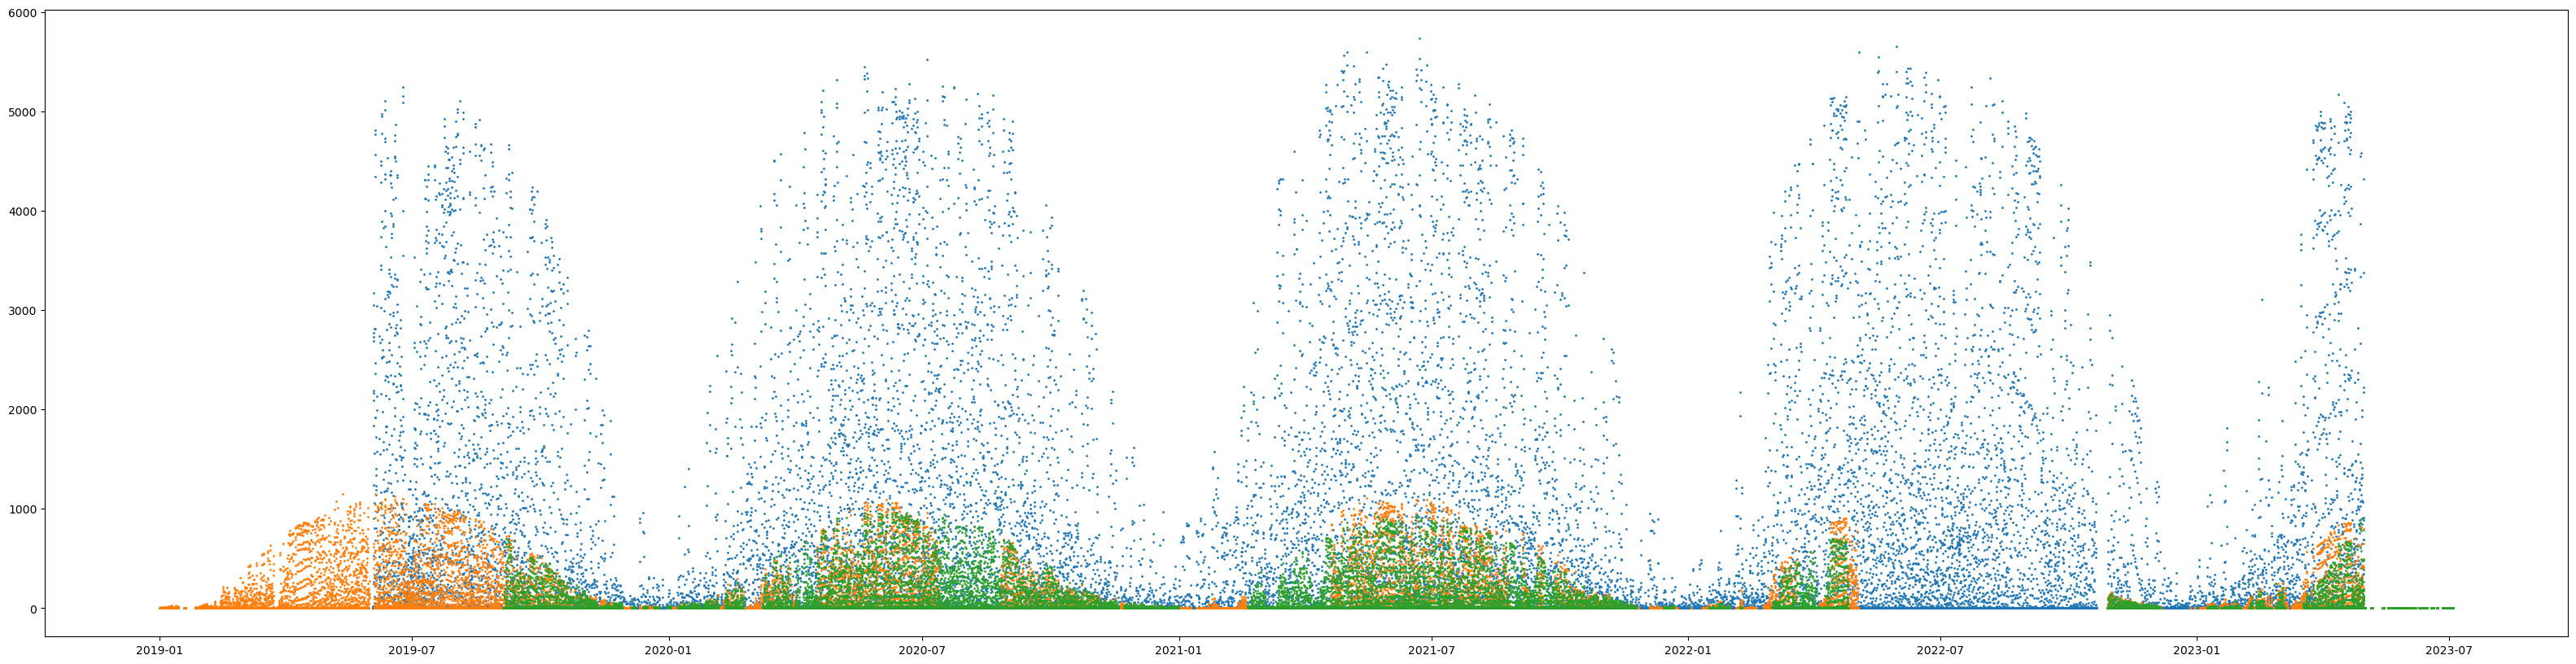

In [377]:
plt.figure(figsize=(40, 10))
plt.scatter(y[y.location == "A"].time, y[y.location == "A"]["pv_measurement"], s=1)
plt.scatter(y[y.location == "B"].time, y[y.location == "B"]["pv_measurement"], s=1)
plt.scatter(y[y.location == "C"].time, y[y.location == "C"]["pv_measurement"], s=1)

### Combine X and y

In [378]:
# Combine X and y on date_forecast and location. Drop rows where a row does not exist in both X and y.

data = pd.merge(
    X, y, left_on=["date_forecast", "location"], right_on=["time", "location"]
).drop(columns=["time"])

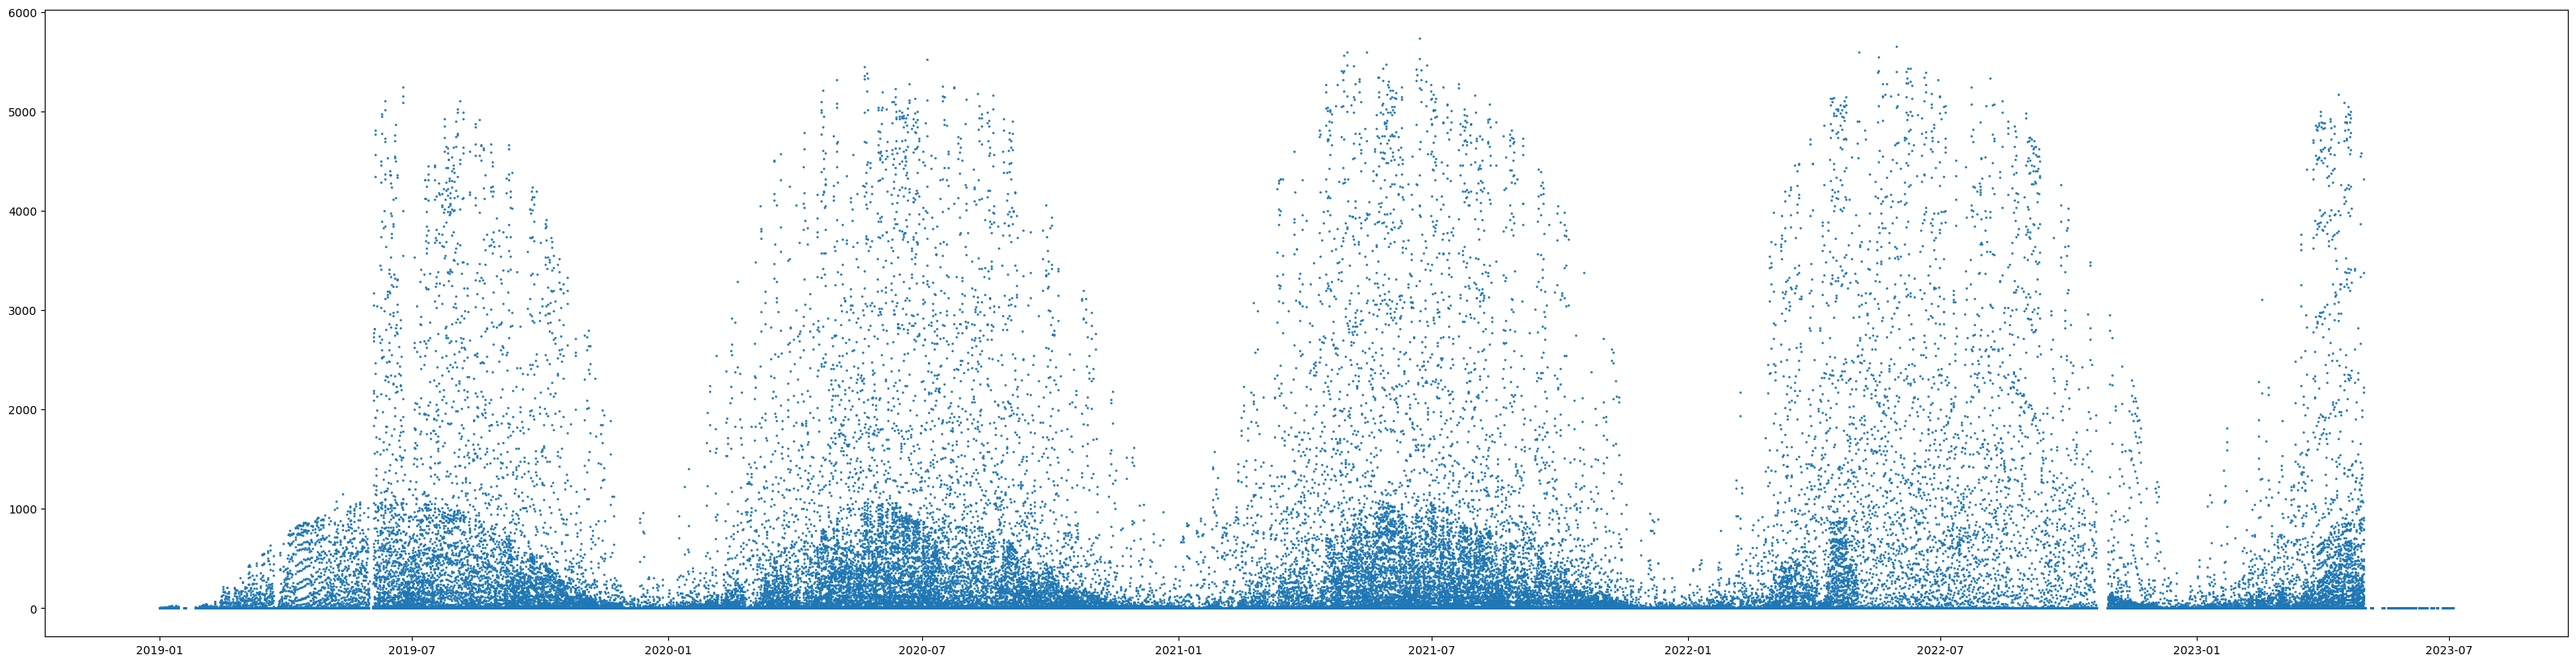

In [379]:
plt.figure(figsize=(40, 10))
plt.scatter(data.date_forecast, data["pv_measurement"], s=1)

### Feature Engineering

#### Add sinus and cosinus features

In [397]:
# Function that sinus and cosinus transform a column

def add_sin_cos(df, column_name, period):
    """
    Add sinus and cosinus transformed columns for the given column.

    Parameters:
    - df: DataFrame to add the transformed columns to.
    - column_name: Name of the column to transform.
    - period: Period of the sinus and cosinus functions.
    """
    df[f"{column_name}_sin"] = np.sin(2 * np.pi * df[column_name] / period)
    df[f"{column_name}_cos"] = np.cos(2 * np.pi * df[column_name] / period)

# Add sinus and cosinus transformed columns for time

data["hour"] = data["date_forecast"].dt.hour
data["month"] = data["date_forecast"].dt.month

add_sin_cos(data, "hour", 24)
add_sin_cos(data, "month", 12)